In [109]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from IPython.display import clear_output

In [110]:
class Q_Learning:
    def __init__(self, learning_rate, discount_factor, exploration_factor, epochs_limit):
        self.env = gym.make('Taxi-v3').env
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_factor
        self.epsilons_history = []
        self.min_epsilon = 0.01
        self.max_epsilon = 1
        self.decay = 0.01
        self.epochs_limit = epochs_limit

        self.q_table = np.zeros([self.env.observation_space.n, self.env.action_space.n])
        self.penalties_during_learning = []

    def learn(self):
        rng = np.random.default_rng()
        for i in range(self.epochs_limit):
            # initialize
            state = self.env.reset()
            done = False

            penalties = 0
            while not done:
                # choose an action
                if rng.uniform(0, 1) < self.epsilon:
                    action = self.env.action_space.sample()
                else:
                    action = np.argmax(self.q_table[state])
                # make new step
                next_state, reward, done, info = self.env.step(action)
                penalties += reward
                # update q_table
                old_q = self.q_table[state, action]
                next_max_q = np.max(self.q_table[next_state])
                new_q = (1 - self.alpha) * old_q + self.alpha * (reward + self.gamma * next_max_q)
                self.q_table[state, action] = new_q
                state = next_state
            # exploration factor decreases with time
            self.update_epsilon(i)
            self.penalties_during_learning.append(penalties)
        print("Training finished.\n")

    def plot_learning_process(self):
        x = range(self.epochs_limit)
        plt.plot(x, self.penalties_during_learning)
        plt.xlabel('Epoch')
        plt.ylabel('Training total penalties')
        plt.title('Total penalties over all epochs in training')
        plt.show()

    def plot_epsilons(self):
        plt.plot(self.epsilons_history)
        plt.xlabel('Epoch')
        plt.ylabel('Epsilon')
        plt.title("Epsilon for epoch")
        plt.show()

    def show_map(self, start_point, with_training):
        state = self.env.encode(start_point[0], start_point[1], start_point[2], start_point[3])
        self.env.s = state
        frames = []
        done = False
        while not done:
            if with_training:
                action = np.argmax(self.q_table[state])
            else:
                action = self.env.action_space.sample()

            state, reward, done, info = self.env.step(action)
            frames.append({
                'frame': self.env.render(mode='human'),
                'state': state,
                'action': action,
                'reward': reward
            })
        print(frames)

    def evaluate(self, evaluations_number, with_training):
        total_epochs, total_penalties = 0, 0
        for _ in range(evaluations_number):
            state = self.env.reset()
            epochs, penalties = 0, 0
            done = False
            while not done:
                if with_training:
                    action = np.argmax(self.q_table[state])
                else:
                    action = self.env.action_space.sample()

                state, reward, done, info = self.env.step(action)
                epochs += 1
                penalties += reward

            total_epochs += epochs
            total_penalties += penalties

        print(f"After {evaluations_number} evaluations:")
        print(f"Average time to finish: {total_epochs / evaluations_number}")
        print(f"Average penalty per epoch: {total_penalties / evaluations_number}")

    def print_frames(self, frames):
        for i, frame in enumerate(frames):
            clear_output(wait=True)
            print(frame['frame'].getvalue())
            print(f"Timestep: {i + 1}")
            print(f"State: {frame['state']}")
            print(f"Action: {frame['action']}")
            print(f"Reward: {frame['reward']}")
            sleep(.1)

    def update_epsilon(self, episode):
        self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.decay * episode)
        self.epsilons_history.append(self.epsilon)

In [111]:
q_learning_1 = Q_Learning(0.1, 0.6, 0.1, 1000)

In [112]:
q_learning_1.learn()

Training finished.



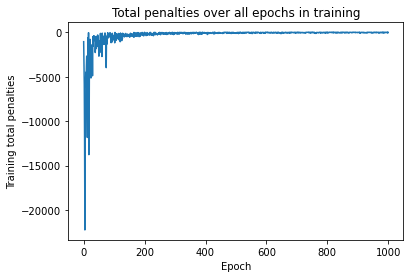

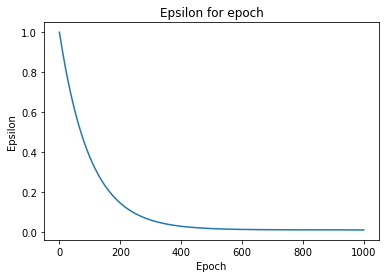

In [113]:
q_learning_1.plot_learning_process()
q_learning_1.plot_epsilons()

In [114]:
q_learning_1.evaluate(50, with_training=False)

After 50 evaluations:
Average time to finish: 2057.2
Average penalty per epoch: -8048.56


In [115]:
q_learning_1.evaluate(50, with_training=True)

KeyboardInterrupt: 

In [116]:
q_learning_1.show_map((4, 1, 2, 0), with_training=False)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | :

In [ ]:
q_learning_1.show_map((4, 1, 2, 0), with_training=True)